In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
#Imports needed for spatial merge of data
import shapely
from shapely.geometry import shape, mapping
import geopandas as gpd
from geopandas.tools import sjoin
import json
import folium
from numba import njit
import shapefile as shp

In [2]:
#opening the vector map
MA_df = gpd.read_file("../input/mass-gis-dataset/CENSUS2010TRACTS_POLY.shp")
print(MA_df.shape)
MA_df.head()

(1472, 22)


,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,...,AREA_ACRES,POP100_RE,HU100_RE,LOGPL94171,LOGSF1,LOGACS0610,LOGSF1C,SHAPE_AREA,SHAPE_LEN,geometry
0,25,021,418003,25021418003,4180.03,Census Tract 4180.03,G5020,1705668.0,2936.0,+42.2350240,...,422.1740,2481,1350,0141872,123764,0003690,0123764,1.708484e+06,6274.185034,"POLYGON ((240678.759 886748.073, 240607.995 88..."
1,25,021,417701,25021417701,4177.01,Census Tract 4177.01,G5020,1543651.0,12275.0,+42.2523398,...,384.4502,5417,2983,0141838,123730,0003683,0123730,1.555821e+06,6229.137913,"POLYGON ((240969.666 890122.806, 240985.156 89..."
2,25,021,417702,25021417702,4177.02,Census Tract 4177.02,G5020,1685529.0,317947.0,+42.2582818,...,416.4918,2765,1109,0141843,123735,0003684,0123735,1.685489e+06,8542.498286,"POLYGON ((242328.221 890545.050, 242276.888 89..."
3,25,021,418102,25021418102,4181.02,Census Tract 4181.02,G5020,771203.0,2371.0,+42.2470410,...,191.1397,3377,1676,0141882,123774,0003693,0123774,7.735182e+05,4540.296101,"POLYGON ((240372.666 888331.030, 240393.057 88..."
4,25,021,418004,25021418004,4180.04,Census Tract 4180.04,G5020,1316466.0,0.0,+42.2383744,...,325.2812,4280,1987,0141874,123766,0003691,0123766,1.316372e+06,5854.497366,"POLYGON ((240687.299 888298.408, 240700.449 88..."


In [3]:
MA_df['NAME10'].unique

<bound method Series.unique of 0       4180.03
1       4177.01
2       4177.02
3       4181.02
4       4180.04
         ...   
1467    7095.01
1468    7095.02
1469    7308.01
1470       7108
1471       7326
Name: NAME10, Length: 1472, dtype: object>

<AxesSubplot:>

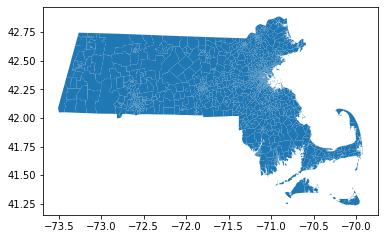

In [4]:
MA_df = MA_df.to_crs('EPSG:4326')
MA_df.plot()

<AxesSubplot:>

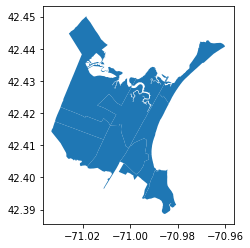

In [13]:
# filter to only relevant tracts
revere_df = MA_df[(MA_df.NAME10 == "1707.02") | (MA_df.NAME10 == "1706.01") | (MA_df.NAME10 == "1701") | (MA_df.NAME10 == "1704") | (MA_df.NAME10 == "1708") | (MA_df.NAME10 == "1702") | (MA_df.NAME10 == "1705.02") | (MA_df.NAME10 == "1707.01") | (MA_df.NAME10 == "1705.01") | (MA_df.NAME10 == "1703")]
revere_df.plot()

In [14]:
df = pd.read_csv("../input/latlongs/latlongs.csv")
def getLatLong(index, latlongs):
    tupe = eval(latlongs)
    return tupe[index]

df['Lat'] = df.apply(lambda x: getLatLong(0,x['LatLong']), axis=1)
df['Long'] = df.apply(lambda x: getLatLong(1,x['LatLong']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Long, df.Lat), crs="EPSG:4326")
gdf.head()

,Export Date,Id,Status,Priority,Address Number,Street Name,Work Type,Date Flagged,Flagged By,Modified Date,...,Time Open,Description,Comments,Finalized Date,QAlert Id (Do not edit),Address Number Filtered,LatLong,Lat,Long,geometry
0,3/4/2021 18:50,12495708,Complete,5,321,Charger Ave,ALL-Street Cleaning,6/29/2020 10:41:49 AM,kimberly.wells@umb.edu,7/3/2020 4:31:51 PM,...,4 days 5 hrs 50 mins,All hands on deck Citywide street cleaning,NaN,7/3/2020 4:31:51 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)
1,3/4/2021 18:50,12510009,Complete,5,321,Charger Ave,ALL-Street Cleaning,7/1/2020 5:00:00 AM,kimberly.wells@umb.edu,7/3/2020 4:31:55 PM,...,2 days 11 hrs 31 mins,All hands on deck Citywide street cleaning,NaN,7/3/2020 4:31:55 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)
2,3/4/2021 18:50,12632922,Complete,5,321,Charger Ave,ALL-Street Cleaning,7/22/2020 5:00:00 AM,kimberly.wells@umb.edu,7/24/2020 12:10:42 PM,...,2 days 7 hrs 10 mins,All hands on deck Citywide street cleaning,NaN,7/24/2020 12:10:42 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)
3,3/4/2021 18:50,12785149,Complete,5,321,Charger Ave,ALL-Street Cleaning,8/12/2020 5:00:00 AM,kimberly.wells@umb.edu,8/12/2020 12:32:33 PM,...,0 days 7 hrs 32 mins,All hands on deck Citywide street cleaning,NaN,8/12/2020 12:32:33 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)
4,3/4/2021 18:50,12909944,Complete,5,321,Charger Ave,ALL-Street Cleaning,9/2/2020 5:00:00 AM,kimberly.wells@umb.edu,11/6/2020 2:15:29 PM,...,65 days 9 hrs 15 mins,All hands on deck Citywide street cleaning,NaN,11/6/2020 2:15:29 PM,NaN,321,"(42.427141, -71.007056)",42.427141,-71.007056,POINT (-71.00706 42.42714)


In [15]:
spatial_merge_df = sjoin(gdf, revere_df, how='left', op='within')
spatial_merge_df = spatial_merge_df[spatial_merge_df['NAME10'].isnull() != True]

In [16]:
newdf = spatial_merge_df[['NAME10','Work Type']]
print(newdf.shape)
newdf.head()

(55495, 2)


,NAME10,Work Type
0,1703,ALL-Street Cleaning
1,1703,ALL-Street Cleaning
2,1703,ALL-Street Cleaning
3,1703,ALL-Street Cleaning
4,1703,ALL-Street Cleaning


In [17]:
work_type_counts = pd.DataFrame(data=newdf['Work Type'].unique(), columns=['Work Type'])

def get_count(work_type):
    return newdf[newdf['Work Type'] == work_type].shape[0]
work_type_counts['Count'] = work_type_counts.apply(lambda x: get_count(x['Work Type']), axis=1)

work_type_counts.sort_values(by='Count', ascending=False).head(20)

,Work Type,Count
26,Cust-Office Trash,5362
86,Parks-Mowing •,3062
102,Sanitation-Public Barrels •,2850
13,Cust-Clean Bathroom,2380
57,HYWY-Pothole •,2268
25,Cust-Office Recycling,2062
31,DR-Catch Basin Clean •,1913
118,SEW-Pump Station Inspct/Clean,1873
10,Cust-Bldg Maintenance,1756
107,Sanitation-Trash Cart Delivery,1728


In [18]:
data_for_map_2 = pd.DataFrame(newdf['NAME10'].unique(), columns=["NAME10"])

def insert_columns_for_wt(work_type_data, NAME10):
    return work_type_data[work_type_data['NAME10'] == NAME10].shape[0]

def make_column(work_type):
    work_type_data = newdf[newdf['Work Type']==work_type]
    data_for_map_2[work_type] = data_for_map_2.apply(lambda x: insert_columns_for_wt(work_type_data, x['NAME10']), axis=1)

work_type_counts.apply(lambda x: make_column(x['Work Type']), axis=1)
data_for_map_2

,NAME10,ALL-Street Cleaning,Cptry-Barrel Stands •,Cptry-Board Up •,Cptry-Building Repairs •,Cptry-City Fence Repair •,Cptry-General •,Cptry-Public Stairs •,Cptry-Railings •,Cust-Amer Legion Clean,...,Water-Mark Out/Dig Safe,Water-Other •,Water-Sink Hole •,Water-Turn-On/Shut-Offs •,Water-Valve Exercise,Water-Valve Inspection,Water-Water box repair •,Water-Water Sampling,Water-Water work •,WSD-Equip Maintenance
0,1703,8,1,0,2,2,0,0,0,1,...,250,281,12,42,22,5,48,12,11,137
1,1707.02,1,1,0,2,0,0,3,0,0,...,136,53,3,18,8,4,8,3,4,0
2,1702,1,0,1,0,0,1,0,0,0,...,149,63,11,25,21,5,25,8,4,3
3,1701,0,1,0,3,4,1,0,0,1,...,188,149,9,31,8,7,42,10,7,2
4,1708,0,1,0,0,1,0,6,1,0,...,164,51,13,23,1,4,17,11,4,0
5,1706.01,0,1,0,5,5,2,0,1,617,...,202,121,14,32,16,2,38,10,11,2
6,1704,0,0,1,3,1,0,1,0,15,...,117,80,10,31,16,1,32,6,2,2
7,1705.01,0,0,0,1,1,1,2,0,5,...,57,112,6,42,38,8,15,6,4,24
8,1705.02,0,0,0,0,5,0,1,0,0,...,84,37,15,16,32,43,7,4,2,6
9,1707.01,0,0,0,0,1,0,0,0,0,...,50,53,2,20,4,0,6,13,5,5


In [19]:
merged = revere_df.set_index('NAME10').join(data_for_map_2.set_index('NAME10'))
merged

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAMELSAD10,MTFCC10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,...,Water-Mark Out/Dig Safe,Water-Other •,Water-Sink Hole •,Water-Turn-On/Shut-Offs •,Water-Valve Exercise,Water-Valve Inspection,Water-Water box repair •,Water-Water Sampling,Water-Water work •,WSD-Equip Maintenance
NAME10,,,,,,,,,,,,,,,,,,,,,
1708,25,025,170800,25025170800,Census Tract 1708,G5020,843082.0,503599.0,+42.3958704,-070.9841693,...,164,51,13,23,1,4,17,11,4,0
1704,25,025,170400,25025170400,Census Tract 1704,G5020,2334595.0,264950.0,+42.4239901,-070.9983953,...,117,80,10,31,16,1,32,6,2,2
1703,25,025,170300,25025170300,Census Tract 1703,G5020,3945724.0,496855.0,+42.4308837,-071.0147469,...,250,281,12,42,22,5,48,12,11,137
1702,25,025,170200,25025170200,Census Tract 1702,G5020,998409.0,0.0,+42.4167928,-071.0198545,...,149,63,11,25,21,5,25,8,4,3
1701,25,025,170100,25025170100,Census Tract 1701,G5020,1462306.0,2839.0,+42.4107259,-071.0218234,...,188,149,9,31,8,7,42,10,7,2
1706.01,25,025,170601,25025170601,Census Tract 1706.01,G5020,1277344.0,85936.0,+42.4073348,-071.0076986,...,202,121,14,32,16,2,38,10,11,2
1707.02,25,025,170702,25025170702,Census Tract 1707.02,G5020,685965.0,0.0,+42.4065669,-070.9974758,...,136,53,3,18,8,4,8,3,4,0
1705.02,25,025,170502,25025170502,Census Tract 1705.02,G5020,923972.0,1163145.0,+42.4359498,-070.9711452,...,84,37,15,16,32,43,7,4,2,6
1705.01,25,025,170501,25025170501,Census Tract 1705.01,G5020,955744.0,593136.0,+42.4164501,-070.9896720,...,57,112,6,42,38,8,15,6,4,24


In [ ]:
name10s = data_for_map_2['NAME10'].to_numpy()
name10s
filtered_df = MA_df[MA_df['NAME10'].isin(name10s)]
revere_df = filtered_df

In [ ]:
# map = folium.Map(location = [42.406,-71.010], tiles = "OpenStreetMap", zoom_start = 12)
# map

In [ ]:
# import contextily as ctx

# ax = merged.plot(figsize=(10, 10), alpha=0.5, edgecolor='k', column='Cust-Office Trash', legend=True)
# ctx.add_basemap(ax, zoom=12)

In [ ]:
# generates a map for any work type

def normalize_col(val, max_val):
    return val / max_val

def any_cat(work_type):
    work_type_data_maps = merged[merged[work_type].isnull() != True]
    max_val = work_type_data_maps[work_type].max()
    work_type_data_maps['NormalizedVal'] = work_type_data_maps.apply(lambda x: normalize_col(x[work_type], max_val), axis=1)
    
    default_location=[42.408428, -71.011993]

    base_map = folium.Map(location=default_location, tiles="Stamen Toner", zoom_start=13)

    for i, r in work_type_data_maps.iterrows():
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = geo_j.replace('"properties": {}', '"properties": {"opacity": '+str(min(1,r['NormalizedVal']*5))+'}')
   
        geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {'fillColor': 'orange', 'fillOpacity':x['properties']['opacity'], 'opacity': 0.2})
        folium.Popup(work_type+': ' + str(r[work_type])).add_to(geo_j)
        geo_j.add_to(base_map)
    return base_map

bm = any_cat('Sanitation-Public Barrels •')
bm

In [ ]:
import os
os.mkdir('out')

In [ ]:
def gen_and_save_map(work_type):
    work_str = work_type.replace(" ", "").replace("/", "-").replace("•", "")
    print(work_str)
    bm = any_cat(work_type)
    bm.save('./out/'+work_str+".html")

# work_type_counts.apply(lambda x: gen_and_save_map(x['Work Type']), axis=1)

In [25]:
import plotly.express as px
import geopandas as gpd
import shutil, os
shutil.rmtree("out")
os.mkdir("out")
# os.remove("stuff.zip")

def gen_and_save_map_plotly(work_type):
    work_str = work_type.replace(" ", "").replace("/", "-").replace("•", "")
    print(work_str)
    work_type_map = merged[merged[work_type].isnull() != True]
    fig = px.choropleth(work_type_map,
                       geojson=work_type_map.geometry,
                       locations=work_type_map.index,
                       color=work_type,
                       projection="mercator")
    fig.update_geos(fitbounds="locations", visible=False)
    fig.write_html("out/"+work_str+".div", include_plotlyjs=False, full_html=False)

work_type_counts.apply(lambda x: gen_and_save_map_plotly(x['Work Type']), axis=1)

ALL-StreetCleaning
Cptry-BarrelStands
Cptry-BoardUp
Cptry-BuildingRepairs
Cptry-CityFenceRepair
Cptry-General
Cptry-PublicStairs
Cptry-Railings
Cust-AmerLegionClean
Cust-BathroomResupply
Cust-BldgMaintenance
Cust-Boiler-Heatcheck
Cust-ChambersCheck
Cust-CleanBathroom
Cust-CleanDitch
Cust-CleanElevator
Cust-CleanMayor'sOfc
Cust-Cleaning
Cust-EquipmentMaintenance
Cust-Events
Cust-FurnitureMove-Removal
Cust-Inmates-Roca
Cust-MailDuty
Cust-Mowing
Cust-Newspapers
Cust-OfficeRecycling
Cust-OfficeTrash
Cust-Open-CloseCityHall
Cust-ResupplyOffices
Cust-SoapDispensers
Cust-WashFloor
DR-CatchBasinClean
DR-CatchBasinInspect
DR-CatchBasinRebuild
DR-Clvrt&TrashRackClean
DR-ClvrtRepair
DR-DrainPumpStation
DR-InspctDrainContractor
DR-LateralDrainClean
DR-MarkOut-DigSafe
DR-MissingGrate
DR-MS4OutfallInspect
DR-Other
DR-StormCCTV
DR-StormCulvertLocate
DR-StormMainCleaning
DR-StormManholeInspection
DR-StormManholeLocate
DR-StormOutfall
DR-TideGateCleaning
DR-TideGateMaintenance
HYWY-ClearDebris-Pavement

0      None
1      None
2      None
3      None
4      None
       ... 
178    None
179    None
180    None
181    None
182    None
Length: 183, dtype: object

In [ ]:
import os, shutil
shutil.rmtree("comps")
os.mkdir("comps")
categories = []
for filename in os.listdir("./out"):
    if filename.endswith(".html"):
        category, _ = filename.split(".")
        categories.append(category)

def compenetify_file(filename):
    """
    Turns a file into a valid React component
    """
    header = "function mapComponent(props) {\n\treturn ("
    file_str = open("./out/"+filename+".html", 'r').read()
    footer = "\t);\n}\nexport default mapComponent;"
    with open(f"./comps/{filename}.jsx", "w+") as text_file:
        print(f"{header}\n{file_str}\n{footer}", file=text_file)
    print(filename)
#     print(file_str)
for cat in categories:
    compenetify_file(cat)

In [26]:
import os
import zipfile
    
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))
      
zipf = zipfile.ZipFile('files.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('out/', zipf)
zipf.close()